In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
mpl.rcParams['lines.linewidth'] = 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
%matplotlib inline

# 데이터 불러오기 및 전처리

In [2]:
# Load the datas
product = pd.read_csv('product.csv', dtype={"CLNT_ID": np.str, "SESS_ID": np.str, "PD_C": np.str}, thousands=",", usecols = [0,1,2,3,5,6])
custom = pd.read_csv('Custom.csv',dtype={"CLNT_ID": np.str})
session = pd.read_csv('Session.csv',thousands=",", dtype={"CLNT_ID": np.str, "SESS_ID": np.str},usecols=[0,1,3,4,5,6,7])
master = pd.read_csv('Master.csv', dtype={"PD_C": np.str})
# 성별을 더미화 시킵니다.
dummies = pd.get_dummies(custom['CLNT_GENDER'], prefix='GENDER')
custom = pd.concat([custom, dummies], axis=1)
custom.drop("CLNT_GENDER", axis=1, inplace=True)

In [3]:
# 제품정보와 고객정보를 합칩니다.
m1 = pd.merge(product, custom, on='CLNT_ID', how = 'inner')


In [4]:
# 세션 정보에서 널 값을 제거하고, 세션 날짜의 월 컬럼을 생성합니다.
session.dropna(inplace=True)
session['SESS_DT'] = pd.to_datetime(session['SESS_DT'], format="%Y%m%d")
session['SESS_month'] = pd.DatetimeIndex(session['SESS_DT']).month
session.head()


,CLNT_ID,SESS_ID,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,SESS_month
0,5873599,08641867,2018-05-09,82.0,1890.0,mobile,Daejeon,5
1,5873599,06616320,2018-06-11,105.0,1604.0,mobile,Busan,6
2,5873599,05886172,2018-06-24,41.0,632.0,mobile,Daejeon,6
3,5873884,01050889,2018-09-13,160.0,1035.0,mobile,Gyeonggi-do,9
4,5874461,10298270,2018-04-12,13.0,298.0,mobile,Seoul,4


In [5]:
#categorical variable to dummy - 클러스터링을 하기 위해 범주형 변수들을 더미화시킵니다.
categorical_features = ['DVC_CTG_NM', 'ZON_NM', 'SESS_month']
prefix_name = ["DVC","ZON","month"]

for i in range(3):
    dummies = pd.get_dummies(session[categorical_features[i]], prefix=prefix_name[i])
    session = pd.concat([session, dummies], axis=1)
    session.drop(categorical_features[i], axis=1, inplace=True)
session.head()

,CLNT_ID,SESS_ID,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_desktop,DVC_mobile,DVC_tablet,ZON_Busan,ZON_Chungcheongbuk-do,ZON_Chungcheongnam-do,ZON_Daegu,ZON_Daejeon,ZON_Gangwon-do,ZON_Gwangju,ZON_Gyeonggi-do,ZON_Gyeongsangbuk-do,ZON_Gyeongsangnam-do,ZON_Incheon,ZON_Jeju-do,ZON_Jeollabuk-do,ZON_Jeollanam-do,ZON_Seoul,ZON_Ulsan,month_4,month_5,month_6,month_7,month_8,month_9
0,5873599,08641867,2018-05-09,82.0,1890.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5873599,06616320,2018-06-11,105.0,1604.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,5873599,05886172,2018-06-24,41.0,632.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,5873884,01050889,2018-09-13,160.0,1035.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5874461,10298270,2018-04-12,13.0,298.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [6]:
# 세션 정보와 고객정보를 합칩니다.
m1 = pd.merge(m1, session, on=['CLNT_ID','SESS_ID'], how = 'inner')


In [7]:
# 마스터 데이터의 상품 분류 컬럼을 더미화 시킵니다.
labels, uniques = pd.factorize(master['CLAC1_NM'],sort=True)

dummies = pd.get_dummies(labels, prefix='CLAC1')
master = pd.concat([master, dummies], axis=1)
master.drop("CLAC1_NM", axis=1, inplace=True)
master.head()

,PD_C,PD_NM,CLAC2_NM,CLAC3_NM,CLAC1_0,CLAC1_1,CLAC1_2,CLAC1_3,CLAC1_4,CLAC1_5,CLAC1_6,CLAC1_7,CLAC1_8,CLAC1_9,CLAC1_10,CLAC1_11,CLAC1_12,CLAC1_13,CLAC1_14,CLAC1_15,CLAC1_16,CLAC1_17,CLAC1_18,CLAC1_19,CLAC1_20,CLAC1_21,CLAC1_22,CLAC1_23,CLAC1_24,CLAC1_25,CLAC1_26,CLAC1_27,CLAC1_28,CLAC1_29,CLAC1_30,CLAC1_31,CLAC1_32,CLAC1_33,CLAC1_34,CLAC1_35,CLAC1_36
0,064382,언더아머 남성 UA HG 아머 모크 LS 1289559-001 - 블랙 / MD[95],남성일반스포츠의류,남성스포츠티셔츠,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,062282,여자 플라워덧신 2족선물세트 17403-2set,여성양말류,여성일반양말,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,061729,88A2933253배트맨스웨트티 - 블랙 / 130,유아의류상의,영유아티셔츠/탑,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,061537,"닥터마틴 아드리안 블랙, 체리레드 - 02_체리레드 / 250mm(6)",남성화,남성부츠,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,058820,여성 그레이 스트라이프 퍼프 소매 블라우스 (128865YQ33) - 회색(앤틱실버...,남성의류상의,남성남방셔츠,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# 최종적으로 마스터와 모든 데이터를 합칩니다.
m1 = pd.merge(m1, master, on=['PD_C'], how = 'inner')
m1.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,CLNT_AGE,GENDER_F,GENDER_M,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_desktop,DVC_mobile,DVC_tablet,ZON_Busan,ZON_Chungcheongbuk-do,ZON_Chungcheongnam-do,ZON_Daegu,ZON_Daejeon,ZON_Gangwon-do,ZON_Gwangju,ZON_Gyeonggi-do,ZON_Gyeongsangbuk-do,ZON_Gyeongsangnam-do,ZON_Incheon,ZON_Jeju-do,ZON_Jeollabuk-do,ZON_Jeollanam-do,ZON_Seoul,ZON_Ulsan,month_4,month_5,month_6,month_7,month_8,month_9,PD_NM,CLAC2_NM,CLAC3_NM,CLAC1_0,CLAC1_1,CLAC1_2,CLAC1_3,CLAC1_4,CLAC1_5,CLAC1_6,CLAC1_7,CLAC1_8,CLAC1_9,CLAC1_10,CLAC1_11,CLAC1_12,CLAC1_13,CLAC1_14,CLAC1_15,CLAC1_16,CLAC1_17,CLAC1_18,CLAC1_19,CLAC1_20,CLAC1_21,CLAC1_22,CLAC1_23,CLAC1_24,CLAC1_25,CLAC1_26,CLAC1_27,CLAC1_28,CLAC1_29,CLAC1_30,CLAC1_31,CLAC1_32,CLAC1_33,CLAC1_34,CLAC1_35,CLAC1_36
0,4140076,10189797,13,570603,데상트,39000,40,1,0,2018-04-13,18.0,113.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,[데상트] 스포츠베이직 빅로고 티셔츠 - DMGR_DMELANGE / 115,남성일반스포츠의류,남성스포츠티셔츠,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4148106,06537318,21,570603,데상트,39000,30,1,0,2018-06-13,20.0,144.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,[데상트] 스포츠베이직 빅로고 티셔츠 - DMGR_DMELANGE / 115,남성일반스포츠의류,남성스포츠티셔츠,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4148106,06662803,94,570603,데상트,39000,30,1,0,2018-06-11,93.0,1371.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,[데상트] 스포츠베이직 빅로고 티셔츠 - DMGR_DMELANGE / 115,남성일반스포츠의류,남성스포츠티셔츠,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5298612,04443505,129,570603,데상트,39000,30,1,0,2018-07-17,179.0,1199.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,[데상트] 스포츠베이직 빅로고 티셔츠 - DMGR_DMELANGE / 115,남성일반스포츠의류,남성스포츠티셔츠,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5553084,06453463,55,570603,데상트,39000,30,1,0,2018-06-14,123.0,2804.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,[데상트] 스포츠베이직 빅로고 티셔츠 - DMGR_DMELANGE / 115,남성일반스포츠의류,남성스포츠티셔츠,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# 고객별로 각 정보들의 평균 데이터를 만들어냅니다.
m1_mean = m1.groupby(['CLNT_ID'])['HITS_SEQ','PD_BUY_AM','TOT_PAG_VIEW_CT','TOT_SESS_HR_V','CLNT_AGE','GENDER_F','GENDER_M'].agg(['mean'])
m1_mean.head()

,HITS_SEQ,PD_BUY_AM,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,CLNT_AGE,GENDER_F,GENDER_M
,mean,mean,mean,mean,mean,mean,mean
CLNT_ID,,,,,,,
0000008,57.000000,38000.000000,46.500000,417.000000,20,0,1
0000014,284.000000,34900.000000,256.000000,7098.000000,30,1,0
0000032,58.000000,15360.000000,98.200000,2169.000000,40,0,1
0000056,47.333333,7933.333333,45.666667,1157.666667,40,1,0
0000058,209.000000,21850.000000,195.000000,3161.000000,30,1,0


In [10]:
# 고객별로 접속월, 구매 상품, 접속 지역의 데이터를 만들어냅니다.
m1_factor = m1.loc[:, m1.columns.str.startswith('DVC') | m1.columns.str.startswith('ZON') | 
                   m1.columns.str.startswith('month') | m1.columns.str.startswith('CLAC1')]
m1_sum = pd.concat([m1['CLNT_ID'], m1_factor], axis=1).groupby(['CLNT_ID']).agg(['sum'])
m1_sum.head()

,DVC_desktop,DVC_mobile,DVC_tablet,ZON_Busan,ZON_Chungcheongbuk-do,ZON_Chungcheongnam-do,ZON_Daegu,ZON_Daejeon,ZON_Gangwon-do,ZON_Gwangju,ZON_Gyeonggi-do,ZON_Gyeongsangbuk-do,ZON_Gyeongsangnam-do,ZON_Incheon,ZON_Jeju-do,ZON_Jeollabuk-do,ZON_Jeollanam-do,ZON_Seoul,ZON_Ulsan,month_4,month_5,month_6,month_7,month_8,month_9,CLAC1_0,CLAC1_1,CLAC1_2,CLAC1_3,CLAC1_4,CLAC1_5,CLAC1_6,CLAC1_7,CLAC1_8,CLAC1_9,CLAC1_10,CLAC1_11,CLAC1_12,CLAC1_13,CLAC1_14,CLAC1_15,CLAC1_16,CLAC1_17,CLAC1_18,CLAC1_19,CLAC1_20,CLAC1_21,CLAC1_22,CLAC1_23,CLAC1_24,CLAC1_25,CLAC1_26,CLAC1_27,CLAC1_28,CLAC1_29,CLAC1_30,CLAC1_31,CLAC1_32,CLAC1_33,CLAC1_34,CLAC1_35,CLAC1_36
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
CLNT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000008,0.0,2.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0.0
0000014,0.0,2.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0.0
0000032,0.0,5.0,0,5.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0.0,0,0,0,3.0,0,0,0,0,0,0,0,0,2,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0
0000056,0.0,3.0,0,3.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,2,0,0.0
0000058,0.0,6.0,0,6.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0,0.0,0,0,0,5.0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0


## 최종 데이터셋
1. 고객별 평균 접속시간, 구매금액과 나이, 성별 데이터
2. 고객별 총 접속횟수, 들어온 모든 지역, 구매한 모든 상품 데이터
이 두개를 결합하여 클러스터링을 진행합니다.

In [11]:
m2 = pd.concat([m1_mean, m1_sum ], axis=1)
m2.head()

,HITS_SEQ,PD_BUY_AM,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,CLNT_AGE,GENDER_F,GENDER_M,DVC_desktop,DVC_mobile,DVC_tablet,ZON_Busan,ZON_Chungcheongbuk-do,ZON_Chungcheongnam-do,ZON_Daegu,ZON_Daejeon,ZON_Gangwon-do,ZON_Gwangju,ZON_Gyeonggi-do,ZON_Gyeongsangbuk-do,ZON_Gyeongsangnam-do,ZON_Incheon,ZON_Jeju-do,ZON_Jeollabuk-do,ZON_Jeollanam-do,ZON_Seoul,ZON_Ulsan,month_4,month_5,month_6,month_7,month_8,month_9,CLAC1_0,CLAC1_1,CLAC1_2,CLAC1_3,CLAC1_4,CLAC1_5,CLAC1_6,CLAC1_7,CLAC1_8,CLAC1_9,CLAC1_10,CLAC1_11,CLAC1_12,CLAC1_13,CLAC1_14,CLAC1_15,CLAC1_16,CLAC1_17,CLAC1_18,CLAC1_19,CLAC1_20,CLAC1_21,CLAC1_22,CLAC1_23,CLAC1_24,CLAC1_25,CLAC1_26,CLAC1_27,CLAC1_28,CLAC1_29,CLAC1_30,CLAC1_31,CLAC1_32,CLAC1_33,CLAC1_34,CLAC1_35,CLAC1_36
,mean,mean,mean,mean,mean,mean,mean,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
CLNT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000008,57.000000,38000.000000,46.500000,417.000000,20,0,1,0.0,2.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0.0
0000014,284.000000,34900.000000,256.000000,7098.000000,30,1,0,0.0,2.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0.0
0000032,58.000000,15360.000000,98.200000,2169.000000,40,0,1,0.0,5.0,0,5.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0.0,0,0,0,3.0,0,0,0,0,0,0,0,0,2,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0
0000056,47.333333,7933.333333,45.666667,1157.666667,40,1,0,0.0,3.0,0,3.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,2,0,0.0
0000058,209.000000,21850.000000,195.000000,3161.000000,30,1,0,0.0,6.0,0,6.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0,0.0,0,0,0,5.0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0


In [12]:
m2.columns = m2.columns.get_level_values(0)
m2.head()

,HITS_SEQ,PD_BUY_AM,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,CLNT_AGE,GENDER_F,GENDER_M,DVC_desktop,DVC_mobile,DVC_tablet,ZON_Busan,ZON_Chungcheongbuk-do,ZON_Chungcheongnam-do,ZON_Daegu,ZON_Daejeon,ZON_Gangwon-do,ZON_Gwangju,ZON_Gyeonggi-do,ZON_Gyeongsangbuk-do,ZON_Gyeongsangnam-do,ZON_Incheon,ZON_Jeju-do,ZON_Jeollabuk-do,ZON_Jeollanam-do,ZON_Seoul,ZON_Ulsan,month_4,month_5,month_6,month_7,month_8,month_9,CLAC1_0,CLAC1_1,CLAC1_2,CLAC1_3,CLAC1_4,CLAC1_5,CLAC1_6,CLAC1_7,CLAC1_8,CLAC1_9,CLAC1_10,CLAC1_11,CLAC1_12,CLAC1_13,CLAC1_14,CLAC1_15,CLAC1_16,CLAC1_17,CLAC1_18,CLAC1_19,CLAC1_20,CLAC1_21,CLAC1_22,CLAC1_23,CLAC1_24,CLAC1_25,CLAC1_26,CLAC1_27,CLAC1_28,CLAC1_29,CLAC1_30,CLAC1_31,CLAC1_32,CLAC1_33,CLAC1_34,CLAC1_35,CLAC1_36
CLNT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000008,57.000000,38000.000000,46.500000,417.000000,20,0,1,0.0,2.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0.0
0000014,284.000000,34900.000000,256.000000,7098.000000,30,1,0,0.0,2.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0.0
0000032,58.000000,15360.000000,98.200000,2169.000000,40,0,1,0.0,5.0,0,5.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0.0,0,0,0,3.0,0,0,0,0,0,0,0,0,2,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0
0000056,47.333333,7933.333333,45.666667,1157.666667,40,1,0,0.0,3.0,0,3.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,2,0,0.0
0000058,209.000000,21850.000000,195.000000,3161.000000,30,1,0,0.0,6.0,0,6.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0,0.0,0,0,0,5.0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0


그 중에서도 30대 남자인 사람들의 클러스터링을 진행합니다.

In [13]:
data_cluster=m2

In [14]:
cluster = data_cluster.loc[(data_cluster['GENDER_M'] == 1) & (data_cluster['CLNT_AGE'] == 30)]
cluster = cluster.drop(['GENDER_F','GENDER_M','CLNT_AGE'], axis=1)
#대대분류 삭제
cluster_drop = cluster.drop(cluster.loc[:, cluster.columns.str.startswith('CLAC1')], axis = 1)
cluster_drop.shape

(41868, 29)

정확도를 위해 표준화를 시켜줍니다.

In [15]:
mms = MinMaxScaler()
mms.fit(cluster_drop) #대대분류 뺀 column들만 갖고
cluster_transformed = mms.transform(cluster_drop)

최적의 군집 갯수를 찾기 위해 elbow method를 수행합니다.

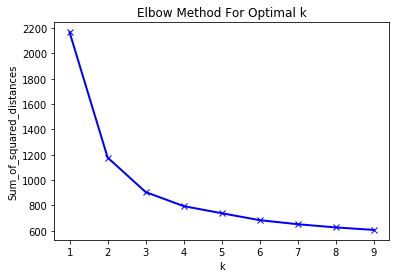

In [16]:
SSD = []

for k in range(1,10):
    km = KMeans(n_clusters = k)
    km = km.fit(cluster_transformed)
    SSD.append(km.inertia_)
    
plt.plot(range(1,10), SSD, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

최적으로 뽑힌 3개를 이용해 클러스터링을 진행합니다.

In [17]:
k=3
km = KMeans(n_clusters = k, algorithm = 'auto')
km.fit(cluster_transformed) # 데이터를 이용하여 클러스터링을 위한 학습 시작하고 중심점 추출
km_predict = pd.DataFrame(km.predict(cluster_transformed)) # 학습된 모델이 맞춰 라벨 리턴
km_predict.columns = ['predict']

각 뽑힌 집단에 속한 고객들의 수입니다.

In [18]:
cluster_transformed = pd.DataFrame(cluster_transformed)
cluster_transformed.columns = cluster_drop.columns
cluster_transformed.index = cluster.index

In [19]:
cluster_transformed['predict'] = km.predict(cluster_transformed)
cluster_transformed['predict'].value_counts()

0    27724
2    11434
1     2710
Name: predict, dtype: int64

밑의 결과를 통해 각 집단들의 특성을 파악할 수 있습니다.
- 30대 남자들은 세 집단으로 나눠볼 수 있으며,
- 각 컬럼의 값이 타 집단보다 클 경우 좀 더 그 집단에 중요한 특성이라고 할 수 있습니다.
ex) 모바일의 경우, 1집단이 가장 없고, 태블릿의 경우 1집단이 가장 많습니다.
      사는 지역의 경우 0집단이 부산의 비율이 가장 높습니다.

In [20]:
cluster_transformed.groupby('predict').mean().iloc[:, :]

,HITS_SEQ,PD_BUY_AM,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_desktop,DVC_mobile,DVC_tablet,ZON_Busan,ZON_Chungcheongbuk-do,ZON_Chungcheongnam-do,ZON_Daegu,ZON_Daejeon,ZON_Gangwon-do,ZON_Gwangju,ZON_Gyeonggi-do,ZON_Gyeongsangbuk-do,ZON_Gyeongsangnam-do,ZON_Incheon,ZON_Jeju-do,ZON_Jeollabuk-do,ZON_Jeollanam-do,ZON_Seoul,ZON_Ulsan,month_4,month_5,month_6,month_7,month_8,month_9
predict,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.074743,0.015661,0.085084,0.059443,0.000198,0.016470,0.000561,0.004629,0.000520,0.000897,0.001127,0.000594,0.000538,0.000488,0.003148,0.000814,0.001432,0.001256,0.000828,0.001222,0.000511,0.008496,0.000419,0.011544,0.008452,0.008000,0.004690,0.007646,0.008620
1,0.468280,0.013231,0.546395,0.273610,0.000000,0.030651,0.001439,0.007798,0.001215,0.001430,0.002488,0.001430,0.000654,0.001958,0.006841,0.002172,0.002854,0.002715,0.001858,0.003733,0.001203,0.013410,0.001263,0.018819,0.014306,0.014303,0.008478,0.011975,0.024986
2,0.204394,0.018168,0.246354,0.149281,0.000036,0.030154,0.001128,0.008923,0.000944,0.001853,0.002274,0.001177,0.000974,0.001338,0.005805,0.001773,0.002964,0.002179,0.001484,0.003256,0.001294,0.013784,0.001400,0.020128,0.015732,0.015394,0.008956,0.013288,0.015260
